In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
import cv2
import numpy as np
import scipy
from scipy.misc import imread
import pickle as pickle
import random
import os
import matplotlib.pyplot as plt

# Feature extractor
def extract_features(image_path, vector_size=512):
    image = imread(image_path, mode="RGB")
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        #alg = cv2.ORB_create()
        #alg=cv2.xfeatures2d.SIFT_create()
        #alg=cv2.DescriptorExtractor_create("SIFT")
        alg = cv2.KAZE_create()
        #alg = cv2.SIFT()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        #####
        #sift = cv2.SIFT()
        #sift = cv2.xfeatures2d.SIFT_create()
        #kps, dsc = sift.detectAndCompute(img1,None)
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc


def batch_extractor(images_path, xfiles,pickled_db_path="./features.pck"):
    #files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    files =[images_path+p for p in xfiles]
    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

In [3]:

class Matcher(object):

    def __init__(self, pickled_db_path="./features.pck"):
        with open(pickled_db_path,'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path,image, topn=5):
        features = extract_features(image_path+image)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        #exclude repeat items
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()
    
    

In [4]:
train_df=pd.read_csv('../input/train.csv')
train_df

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,w_dd88965
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33


In [5]:
lista=train_df["Id"].unique()
len(lista)
lista[0:10]

array(['w_f48451c', 'w_c3d896a', 'w_20df2c5', 'new_whale', 'w_dd88965',
       'w_64404ac', 'w_a6f9d33', 'w_581ba42', 'w_cb622a2', 'w_d3b46e7'],
      dtype=object)

In [6]:
train_df=pd.read_csv('../input/train.csv')
sometest=train_df[(train_df["Id"]=='w_20df2c5')]
for x in lista[0:15]:   
    if (x!='new_whale'):
        sometest=sometest.append( train_df[(train_df["Id"]==x)])
    

sometest

,Image,Id
2,00029d126.jpg,w_20df2c5
14794,94e15dfd2.jpg,w_20df2c5
16550,a6766b182.jpg,w_20df2c5
21159,d5098b5a1.jpg,w_20df2c5
0,0000e88ab.jpg,w_f48451c
1111,0af805558.jpg,w_f48451c
2746,1c351b88e.jpg,w_f48451c
10983,6f7abb1be.jpg,w_f48451c
11786,77a44bf94.jpg,w_f48451c
12019,79c77838d.jpg,w_f48451c


In [7]:
images_path = '../input/train/'
#files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
files =[p for p in sometest["Image"]]
print(files)
# getting 3 random images 
sample = random.sample(files, 3)

batch_extractor(images_path,files)
print("DONE")
#ma = Matcher('./features.pck')

['00029d126.jpg', '94e15dfd2.jpg', 'a6766b182.jpg', 'd5098b5a1.jpg', '0000e88ab.jpg', '0af805558.jpg', '1c351b88e.jpg', '6f7abb1be.jpg', '77a44bf94.jpg', '79c77838d.jpg', '9064d5875.jpg', '9fc84d2ae.jpg', 'c1ec12eb6.jpg', 'c64e5e861.jpg', 'c9df69a69.jpg', 'db0699767.jpg', 'e2f1b6c4a.jpg', 'e3f2dbd25.jpg', '0001f9222.jpg', '1d6ccd05a.jpg', '2cccac55a.jpg', 'cad8eabe4.jpg', '00029d126.jpg', '94e15dfd2.jpg', 'a6766b182.jpg', 'd5098b5a1.jpg', '000a6daec.jpg', '01c602e06.jpg', '0706d4216.jpg', '07ac2b767.jpg', '19bb578b1.jpg', '2d4ca80ea.jpg', '2d7ede381.jpg', '46da4bda9.jpg', '5693515f6.jpg', '6d96ef90c.jpg', '749bd29f4.jpg', '779fb45f0.jpg', 'c6e055c12.jpg', 'cfa32fb80.jpg', 'fb929ab01.jpg', 'fc5c53caa.jpg', '0016b897a.jpg', '50e0f92fa.jpg', 'c3bb9b4ca.jpg', 'd146d9d42.jpg', 'f3e3ed3f6.jpg', '001c1ac5f.jpg', 'a0f8f6daa.jpg', '001cae55b.jpg', '01425e516.jpg', '095533ca6.jpg', '13f275380.jpg', '1749cf8d7.jpg', '1a59c266b.jpg', '23d33bd86.jpg', '2ebeb06fb.jpg', '382d62eec.jpg', '6e74208c6.jp

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


Extracting features from image ../input/train/94e15dfd2.jpg
Extracting features from image ../input/train/a6766b182.jpg
Extracting features from image ../input/train/d5098b5a1.jpg
Extracting features from image ../input/train/0000e88ab.jpg
Extracting features from image ../input/train/0af805558.jpg
Extracting features from image ../input/train/1c351b88e.jpg
Extracting features from image ../input/train/6f7abb1be.jpg
Extracting features from image ../input/train/77a44bf94.jpg
Extracting features from image ../input/train/79c77838d.jpg
Extracting features from image ../input/train/9064d5875.jpg
Extracting features from image ../input/train/9fc84d2ae.jpg
Extracting features from image ../input/train/c1ec12eb6.jpg
Extracting features from image ../input/train/c64e5e861.jpg
Extracting features from image ../input/train/c9df69a69.jpg
Extracting features from image ../input/train/db0699767.jpg
Extracting features from image ../input/train/e2f1b6c4a.jpg
Extracting features from image ../input/

Extracting features from image ../input/train/75fdb22ae.jpg
Extracting features from image ../input/train/78a8513fc.jpg
Extracting features from image ../input/train/8be0c62d2.jpg
Extracting features from image ../input/train/a1f3076c8.jpg
Extracting features from image ../input/train/d8adc80c4.jpg
Extracting features from image ../input/train/e930f7403.jpg
Extracting features from image ../input/train/0050ef29d.jpg
Extracting features from image ../input/train/d13f5161a.jpg
DONE


In [10]:
ma = Matcher('./features.pck')

In [11]:
import matplotlib.pyplot as plt
def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()
    
sample = random.sample(files, 1)
sample[0]

'c403395bd.jpg'

In [12]:
print("DONE")

DONE


Query image ===============================
Name             Image         Id
16  00355ff28.jpg  w_cb622a2
True same--> 5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


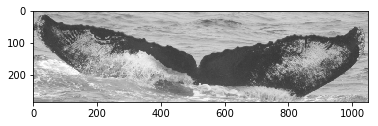

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


Result images ========================================
Match  1.0
Result             Image         Id
16  00355ff28.jpg  w_cb622a2


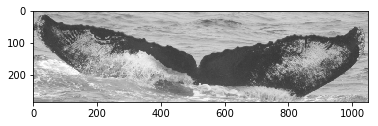

Match  0.7224451038610277
Result                Image         Id
19675  c64e5e861.jpg  w_f48451c


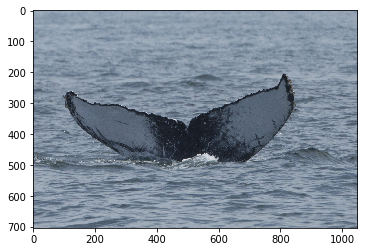

Match  0.7198142241803843
Result            Image         Id
0  0000e88ab.jpg  w_f48451c


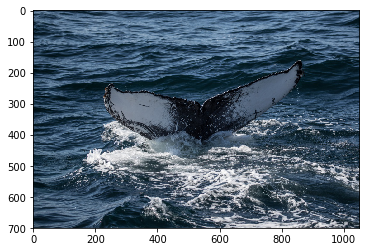

Match  0.7197932281429446
Result             Image         Id
23  004775679.jpg  w_13ae3d4


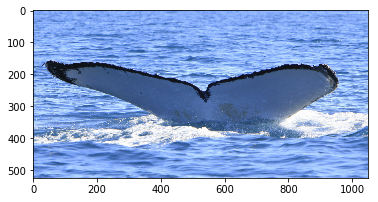

Match  0.7195689794418514
Result                Image         Id
12958  82b7870b8.jpg  w_3de579a


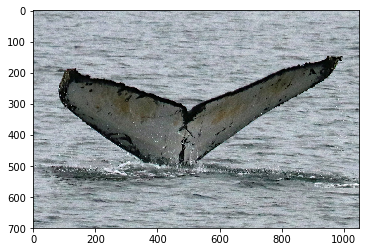

In [13]:

sample = random.sample(files, 1)

for s in sample:
    print ('Query image ===============================')
    print("Name",sometest[sometest["Image"]==s])
    idx=sometest[sometest["Image"]==s].Id.values[0]
    now=sometest[sometest["Id"]==idx]
    
    print("True same-->",len(now))
    show_img("../input/train/"+s)
    names, match = ma.match(image_path='../input/train/',image=s, topn=5)
    
    print ('Result images ========================================')
    for i in range(5):
        # we got cosine distance, less cosine distance between vectors
        # more they similar, thus we subtruct it from 1 to get match value
        print ('Match ' , (1-match[i]))
        print("Result",sometest[sometest["Image"]==names[i]])
        show_img(os.path.join(images_path, names[i]))
        